In [ ]:
pip install transformers

     |████████████████████████████████| 3.1 MB 5.3 MB/s 
     |████████████████████████████████| 59 kB 6.7 MB/s 
     |████████████████████████████████| 3.3 MB 19.6 MB/s 
     |████████████████████████████████| 895 kB 54.5 MB/s 
     |████████████████████████████████| 596 kB 53.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
stemmer = nltk.SnowballStemmer("english")
from nltk.corpus import stopwords
import string
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import itertools
import json
import glob
import numpy as np

In [ ]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ')]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text

In [ ]:
df_positive = pd.read_csv("class1.csv", names=["text"])
df_positive.drop(0, inplace=True)
df_positive['class'] = 1
df_positive

,text,class
1,When a policyholder or insured gets sick or h...,1
2,During 2020 in response to the onset and deve...,1
3,Prolonged periods of low interest rates als...,1
4,Conversely a rise in interest rates could i...,1
5,Further because of the concentration of the...,1
...,...,...
2230,The increase in adjusted PPNR was primarily t...,1
2231,Modest noninterest income growth due to ...,1
2232,Wealth management and trust fees increased ...,1
2233,The 2019 provision increased due to loa...,1


# New Section

In [ ]:
X_negative = []
y_positive = []

for file in glob.glob("./data/*.json"):
    with open(file) as f:
        data = json.load(f)
    for key, val in data.items():
        X_negative.extend(val)

X_negative = list(set(X_negative))
y_negative = [0] * len(X_negative)

data_negative = {'text': X_negative, 'class': y_negative}
df_negative = pd.DataFrame(data_negative)
df_negative

,text,class
0,As of and for the Year Ended December ...,0
1,e Investments in partially owned insurance c...,0
2,The reallocation was computed using fair valu...,0
3,In addition as a publicly held company we a...,0
4,At December lease liabilities...,0
...,...,...
42665,Additionally outside parties may attempt to ...,0
42666,Thus our plans to increase the amount of our...,0
42667,Delinquency data for periods other than d...,0
42668,The Corporation also uses these types of cont...,0


In [ ]:
df_temp = pd.read_csv('data.txt')
X_twitter = df_temp['tweet'].values
np.random.shuffle(X_twitter)


In [ ]:
X_negative = np.setdiff1d(df_negative['text'].values, df_positive['text'].values)
np.random.shuffle(X_negative)
X_negative = X_negative[:len(df_positive['text'].values) - 100].tolist()

X_negative.extend(X_twitter[:100].tolist()) # adding twitter data, 100 records only
y_negative = [0] * len(X_negative)
data_negative = {'text': X_negative, 'class': y_negative}

df_negative = pd.DataFrame(data_negative)
df_negative

,text,class
0,Default related declines in the value of our ...,0
1,Model owners submit models to the MVG for val...,0
2,OVERVIEW Comerica Incorporated the Corp...,0
3,high grade corporate bonds as reported by TRA...,0
4,Minimum Eligible LTD Requirements The minimum...,0
...,...,...
2229,Legislative and Regulatory Developments The E...,0
2230,The fair values are determined using signific...,0
2231,BrokerTec Americas Matched Principal Business...,0
2232,federal statutory rate to our actual income ...,0


In [ ]:
df = pd.concat([df_negative, df_positive], ignore_index=True, sort=False)
df

,text,class
0,Default related declines in the value of our ...,0
1,Model owners submit models to the MVG for val...,0
2,OVERVIEW Comerica Incorporated the Corp...,0
3,high grade corporate bonds as reported by TRA...,0
4,Minimum Eligible LTD Requirements The minimum...,0
...,...,...
4463,The increase in adjusted PPNR was primarily t...,1
4464,Modest noninterest income growth due to ...,1
4465,Wealth management and trust fees increased ...,1
4466,The 2019 provision increased due to loa...,1


In [ ]:
df['text']=df['text'].apply(clean_text)

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
X=df['text']
y=df['class']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=42, stratify = y)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.5",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/

In [ ]:
train_encodings  = tokenizer(x_train.tolist(), padding="max_length", truncation=True, return_attention_mask=True)
test_encodings  = tokenizer(x_test.tolist(), padding="max_length", truncation=True, return_attention_mask=True)


train_dataset = CustomDataset(train_encodings, y_train.tolist())
test_dataset = CustomDataset(test_encodings, y_test.tolist())

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.5",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache 

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=6,              # total number of training epochs
    per_device_eval_batch_size=3,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,
    save_strategy='epoch'
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset             # evaluation dataset

)

trainer.train(resume_from_checkpoint= True)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Loading model from ./results/checkpoint-1425).
***** Running training *****
  Num examples = 3797
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2850
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 3
  Continuing training from global step 1425
  Will skip the first 3 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Step,Training Loss
1500,0.253500
1600,0.279000
1700,0.263500
1800,0.264300
1900,0.221900
2000,0.245800
2100,0.189000
2200,0.182200
2300,0.145500
2400,0.168100


Saving model checkpoint to ./results/checkpoint-1900
Configuration saved in ./results/checkpoint-1900/config.json
Model weights saved in ./results/checkpoint-1900/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2375
Configuration saved in ./results/checkpoint-2375/config.json
Model weights saved in ./results/checkpoint-2375/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-2850
Configuration saved in ./results/checkpoint-2850/config.json
Model weights saved in ./results/checkpoint-2850/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=2850, training_loss=0.09490750664158872, metrics={'train_runtime': 2138.6808, 'train_samples_per_second': 10.652, 'train_steps_per_second': 1.333, 'total_flos': 5994196063211520.0, 'train_loss': 0.09490750664158872, 'epoch': 6.0})

In [ ]:

# Load trained model
model_path = "results/checkpoint-2850"
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)
# Define test trainer
test_trainer = Trainer(model)
# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)
# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

loading configuration file results/checkpoint-2850/config.json
Model config BertConfig {
  "_name_or_path": "results/checkpoint-1425",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.12.5",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file results/checkpoint-2850/pytorch_model.bin
All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForS

In [ ]:
acc_test = sum(y_pred == y_test) / len(y_test) * 100
print(f"Test Accuracy: {acc_test}")

Test Accuracy: 88.52459016393442


In [ ]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.91      0.86      0.88       336
     class 1       0.86      0.91      0.89       335

    accuracy                           0.89       671
   macro avg       0.89      0.89      0.89       671
weighted avg       0.89      0.89      0.89       671



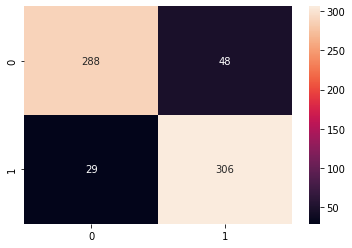

In [ ]:
cm = confusion_matrix(y_test, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')